In [73]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve

from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [43]:
df = pd.read_csv('dataset.csv')

In [44]:
def encode(X):
    X = X.copy() 
    X.drop(columns = ['area_code', 'state'], inplace=True)
    X['international_plan'] = X['international_plan'].map({'no': 0,'yes':1 })
    X['voice_mail_plan'] = X['voice_mail_plan'].map({'no': 0,'yes':1 })
    return X

In [45]:
logreg_pipeline = ImbPipeline([
    ('encode', FunctionTransformer(encode, validate=False)),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter = 500, random_state=42))
])

In [46]:
xgb_pipeline = ImbPipeline([
    ('encode', FunctionTransformer(encode, validate=False)),
    ('smote', SMOTE(random_state=42)),
    ('model', XGBClassifier(n_estimators = 200, max_depth = 6, learning_rate=0.05, random_state=42,eval_metric='auc'))
])

In [47]:
X = df.drop(columns = 'churn')
y = df['churn'].map({'no': 0,'yes':1 })

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [49]:
logreg_pipeline.fit(X_train, y_train)

c:\Users\nitin\OneDrive\Documents\Machine Learning\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('encode', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function enc...00287FD01F920>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pass to func... versionadded:: 0.18",None


In [52]:
xgb_pipeline.fit(X_train, y_train)

,steps,"[('encode', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,"func func: callable, default=NoneThe callable to use for the transformation. This will be passedthe same arguments as transform, with args and kwargs forwarded.If func is None, then func will be the identity function.",<function enc...00287FD01F920>
,"inverse_func inverse_func: callable, default=NoneThe callable to use for the inverse transformation. This will bepassed the same arguments as inverse transform, with args andkwargs forwarded. If inverse_func is None, then inverse_funcwill be the identity function.",None
,"validate validate: bool, default=FalseIndicate that the input X array should be checked before calling``func``. The possibilities are:- If False, there is no input validation.- If True, then X will be converted to a 2-dimensional NumPy array or sparse matrix. If the conversion is not possible an exception is raised... versionchanged:: 0.22 The default of ``validate`` changed from True to False.",False
,"accept_sparse accept_sparse: bool, default=FalseIndicate that func accepts a sparse matrix as input. If validate isFalse, this has no effect. Otherwise, if accept_sparse is false,sparse matrix inputs will cause an exception to be raised.",False
,"check_inverse check_inverse: bool, default=TrueWhether to check that or ``func`` followed by ``inverse_func`` leads tothe original inputs. It can be used for a sanity check, raising awarning when the condition is not fulfilled... versionadded:: 0.20",True
,"feature_names_out feature_names_out: callable, 'one-to-one' or None, default=NoneDetermines the list of feature names that will be returned by the`get_feature_names_out` method. If it is 'one-to-one', then the outputfeature names will be equal to the input feature names. If it is acallable, then it must take two positional arguments: this`FunctionTransformer` (`self`) and an array-like of input feature names(`input_features`). It must return an array-like of output featurenames. The `get_feature_names_out` method is only defined if`feature_names_out` is not None.See ``get_feature_names_out`` for more details... versionadded:: 1.1",None
,"kw_args kw_args: dict, default=NoneDictionary of additional keyword arguments to pass to func... versionadded:: 0.18",None


In [59]:
logreg_y_pred = logreg_pipeline.predict(X_test)
logreg_y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_y_proba)
logreg_cm = confusion_matrix(y_test, logreg_y_pred)


xgb_y_pred = xgb_pipeline.predict(X_test)
xgb_y_proba = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_y_proba)
xgb_cm = confusion_matrix(y_test, xgb_y_pred)


In [61]:
def get_metrics(y_true, y_pred, y_proba):
    return {
        'AUC': roc_auc_score(y_true, y_proba),
        'Precision (Churn)': precision_score(y_true, y_pred),
        'Recall (Churn)': recall_score(y_true, y_pred),
        'F1-Score (Churn)': f1_score(y_true, y_pred),
        'Accuracy': (y_true == y_pred).mean()
    }

logreg_metrics = get_metrics(y_test, logreg_y_pred, logreg_y_proba)
xgb_metrics = get_metrics(y_test, xgb_y_pred, xgb_y_proba)

comparison = pd.DataFrame({'Logistic Regression': logreg_metrics, 'XGBoost': xgb_metrics})

comparison['Improvement'] = comparison['XGBoost'] - comparison['Logistic Regression']
comparison['Improvement %'] = (comparison['Improvement'] / comparison['Logistic Regression'] * 100).round(1)

print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)
print(comparison.round(4))
print("\n" + "=" * 80)

print(f"AUC Improvement: +{comparison.loc['AUC', 'Improvement']:.4f} ({comparison.loc['AUC', 'Improvement %']:.1f}%)")
print("=" * 80)



MODEL COMPARISON
                   Logistic Regression  XGBoost  Improvement  Improvement %
AUC                             0.7716   0.8981       0.1266           16.4
Precision (Churn)               0.2785   0.7302       0.4517          162.2
Recall (Churn)                  0.7333   0.7667       0.0333            4.5
F1-Score (Churn)                0.4037   0.7480       0.3443           85.3
Accuracy                        0.6941   0.9271       0.2329           33.6

AUC Improvement: +0.1266 (16.4%)


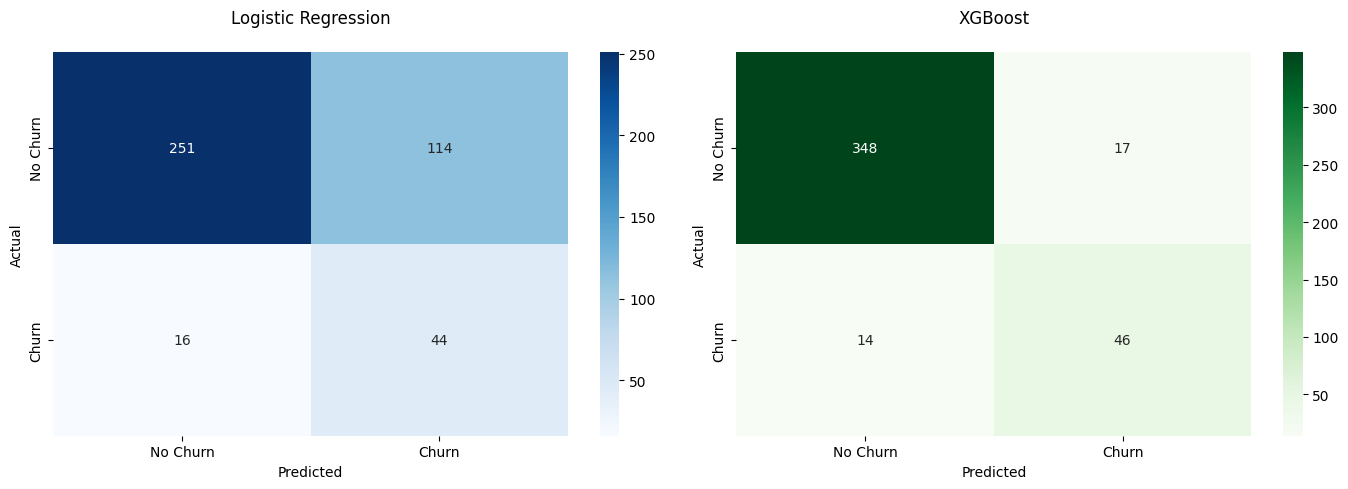

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Logistic Regression\n')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels(['No Churn', 'Churn'])
axes[0].set_yticklabels(['No Churn', 'Churn'])

sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'XGBoost\n')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels(['No Churn', 'Churn'])
axes[1].set_yticklabels(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()



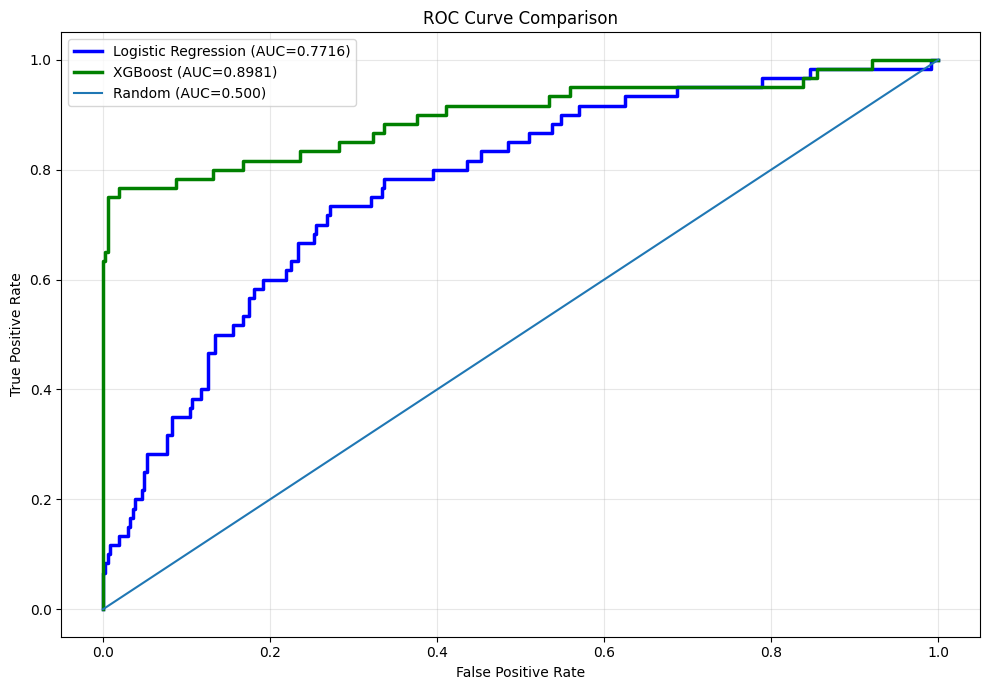

In [78]:
fig, ax = plt.subplots(figsize=(10, 7))

for name, proba, color in [
    ('Logistic Regression', logreg_y_proba, 'blue'),
    ('XGBoost', xgb_y_proba, 'green')
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.4f})', 
            color=color, linewidth=2.5)
    
ax.plot([0, 1], [0, 1], '-', label='Random (AUC=0.500)', linewidth=1.5)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve Comparison')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
